In [114]:
import warnings
warnings.filterwarnings('ignore')
from typing import Final, Dict
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import gym 
import gym_md
import shap
from md_shap import shappy, gen_analysis,gen_config
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import PPO, DQN
from tqdm import tqdm
import cv2
import torch
import torch.nn as nn
from util import debug_env
from itertools import repeat, chain

## Functions


In [115]:
obs_names = ['dist_monster', 'dist_treaure', 'safe_dist_teasure', 'dist_potion', 'safe_dist_potion', 'dist_exit', 'safe_dist_exit', 'HP']
obs_names = ['DM', 'DT', 'SDT', 'DP', 'SDP', 'DE', 'SDE', 'HP']

revert_dict = lambda d: dict(chain(*[zip(val, repeat(key)) for key, val in d.items()]))

def grouped_shap(shap_vals, features, groups):
    groupmap = revert_dict(groups)
    shap_Tdf = pd.DataFrame(shap_vals, columns=pd.Index(features, name='features')).T
    shap_Tdf['group'] = shap_Tdf.reset_index().features.map(groupmap).values
    shap_grouped = shap_Tdf.groupby('group').sum().T
    return shap_grouped

def plot_frequency(ax, x, y, xlabel, ylabel, title):
    sns.barplot(x=x, y=y, ax=ax)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)

def qauntitative_results(explainer, shap_vals, data, df):
    print("----------------------------------------------------Generting quantitative results-------------------------------------------")
    # create shap value df
    df_shap = df[['curr_obs', 'action']]
    shap_valss = []
    policy_classes = ['killer','treasure','runner','potion']

    reshaped_shap_vals = np.transpose(np.array(shap_vals),(1,0,2))
    action_shap_vals=[]
    for i, row in df.iterrows():
        action = row['action']
        # get action taken index
        action_idx = policy_classes.index(action.lower())
        action_shap_vals.append(reshaped_shap_vals[i][action_idx])

    # Add shap_vals to the dataframe
    df_shap["shap_vals"] = pd.Series(action_shap_vals)
    df_shap[obs_names] = pd.DataFrame(df_shap.shap_vals.to_list(), index = df_shap.index)

    # get the top five features for each state
    df_shap= df_shap.join(pd.DataFrame(df_shap[obs_names].abs().apply(lambda x: x.nlargest(5).index.tolist(), axis=1).tolist(), columns=['1st','2nd','3rd','4th','5th']))

    # create rankings dataframe for the whole level by adding up the value counts
    df_rankings = df_shap[['1st','2nd','3rd','4th','5th']].apply(pd.Series.value_counts).sum(axis=1)
    df_rankings = pd.DataFrame(data=df_rankings,columns=['Importance_count']).sort_values(by='Importance_count')

    ax = sns.barplot(x=df_rankings.index, y=df_rankings.Importance_count)
    ax.set(xlabel='Features', ylabel='Times in Top 5 Most Important Features', title="Frequency of a feature being important \nin deciding the chosen action")

    melted_df = pd.melt(df_shap[['action','1st','2nd','3rd','4th','5th']], id_vars=['action'], value_vars=['1st', '2nd', '3rd', '4th', '5th'])
    df_action_rankings = pd.crosstab(index=melted_df['action'], columns=melted_df['value'])

    fig, ax = plt.subplots(1, len(df_action_rankings), figsize=(4 * len(df_action_rankings), 4))

    for i in range(len(df_action_rankings)):
        plot_frequency(ax[i], df_action_rankings.columns, df_action_rankings.iloc[i],
                    xlabel='Features', ylabel='Times in Top 5 Most Important Features',
                    title=f"Frequency of a feature being important \nwhen choosing the {df_action_rankings.index[i]} action")

    plt.tight_layout()
    plt.show() 
    return df_shap, df_rankings, df_action_rankings

## Corralation Stuff

In [126]:
# def change_env_rew(env,reward_dict):
#     if config['reward_scheme'] =="treasure":
        
from md_shap import gen_data
from sklearn import preprocessing


def get_reward_scheme(type):
    rewards  ={}
    if type == "treasure_safe":
        rewards = {
            "TURN": 1,
            "EXIT": 5,
            "KILL": 1,
            "TREASURE":10,
            "POTION": 2,
            "DEAD": -20
        }
        return rewards
    elif type == "treasure_risky":
        rewards = {
            "TURN": 1,
            "EXIT": 5,
            "KILL": 1,
            "TREASURE":20,
            "POTION": 1,
            "DEAD": -10
        }
        return rewards
    elif type == "treasure":
        rewards = {
            "TURN": 2,  #0.2, #2
            "EXIT": 10, #-1, #-10
            "KILL": 0, #-1.5, # -25
            "TREASURE":50, #2.5, # 50
            "POTION": 0, #-1.5, # -25
            "DEAD": -250, #-10 # 250
        }
        return rewards
    elif type == "killer_safe":
        rewards = {
            "TURN": 1,
            "EXIT": 5,
            "KILL": 10,
            "TREASURE":1,
            "POTION": 9,
            "DEAD": -30
        }
        return rewards
    elif type == "killer_risky":
        rewards = {
            "TURN": 1,
            "EXIT": 5,
            "KILL": 20,
            "TREASURE":1,
            "POTION": 2,
            "DEAD": -10
        }
        return rewards
    elif type == "killer":
        rewards = {
            "TURN": 2, #0.2,
            "EXIT": 10, # -1,
            "KILL": 50, #2.5,
            "TREASURE": 0, #-1.5,
            "POTION": 0, #-1.5,
            "DEAD": -250 #-10
        }
        return rewards
    elif type == "runner_safe":
        rewards = {
            "TURN": 1,
            "EXIT": 15,
            "KILL": 1,
            "TREASURE":2,
            "POTION": 3,
            "DEAD": -10
        }
        return rewards
    elif type == "runner_risky":
        rewards = {
            "TURN": 1,
            "EXIT": 30,
            "KILL": 1,
            "TREASURE":1,
            "POTION": 1,
            "DEAD": -5
        }
        return rewards
    elif type == "runner":
        rewards = {
            "TURN": 2, #0.2,
            "EXIT": 50, #2.5,
            "KILL": 0, #-1.5,
            "TREASURE": 0, #-1.5,
            "POTION": 0, # -1.5,
            "DEAD": -250, #-10
        }
        return rewards
    elif type == "clearer_safe":
        rewards = {
            "TURN": 1,
            "EXIT": 5,
            "KILL": 15,
            "TREASURE":18,
            "POTION": 20,
            "DEAD": -15
        }
        return rewards
    elif type == "clearer_risky":
        rewards = {
            "TURN": 1,
            "EXIT": 5,
            "KILL": 18,
            "TREASURE":20,
            "POTION": 20,
            "DEAD": -5
        }
        return rewards
    elif type == "potion":
        rewards = {
            "TURN": 2, #0.2,
            "EXIT": 10, #-1,
            "KILL": 0, #-1.5,
            "TREASURE": 0, #-1.5,
            "POTION": 50, #2.5,
            "DEAD": -250, #-10
        }
        return rewards
    elif type == "switch":
        rewards = {
            "TURN": 1,
            "EXIT": 5,
            "KILL": 10,
            "TREASURE":10,
            "POTION": 10,
            "DEAD": -25
        }
        return rewards
    elif type == "hard":
        rewards= {
            "TURN": 1,
            "EXIT": 20,
            "KILL": 4,
            "TREASURE": 3,
            "POTION": 1,
            "DEAD": -20
        }
        return rewards
    else :
        return 

def get_imporance_weights(reward_scheme):

    rewards = get_reward_scheme(reward_scheme)
    total_rewards = rewards['EXIT'] + rewards['TREASURE'] +rewards['KILL'] +rewards['POTION'] #+ rewards['DEAD']
    importance_wights = {
        'DE': (0.5*rewards['EXIT'])/total_rewards,
        "SDE": (0.5*rewards['EXIT'])/total_rewards,
        "DT": (0.5*rewards['TREASURE'])/total_rewards,
        "SDT": (0.5*rewards['TREASURE'])/total_rewards,
        "DM": (rewards["KILL"])/total_rewards,#(rewards["KILL"]+ 0.25*rewards["DEAD"])/total_rewards, #add DEAD
        "DP": (0.33*rewards["POTION"])/total_rewards,#(0.33*rewards["POTION"]+0.25*rewards["DEAD"])/total_rewards,
        "SDP": (0.33*rewards["POTION"])/total_rewards,#(0.33*rewards["POTION"]+0.25*rewards["DEAD"])/total_rewards,
        "HP": (0.33*rewards["POTION"])/total_rewards,#(0.33*rewards["POTION"]+0.25*rewards["DEAD"])/total_rewards,
    }
    return importance_wights

def get_info(env,config)->Dict:
    env_info ={}
    env_info = env.env
    return env_info

default_config= {
    'lvl':"hard",
    "play_style":"hard",
    "reward_scheme":"hard",
    "action_type": "policy",
    "action_space_type": "discrete",
    "obs_type": "distance",
    "base_path":  "./play_style_models/base/", 
    "exp_type":  "./play_style_models/base/", 
    "learning_algo":"PPO",
}

lvl_list =[
    "hard",
    "check_1",
    "holmgard_0",
    "holmgard_1",
    "holmgard_2",
    "holmgard_3",
    "holmgard_4",
    "holmgard_5",
    "holmgard_6",
    "holmgard_7",
    # "holmgard_8",
    "holmgard_9",
]

configs = gen_config(lvl ="hard",algo ="PPO",obs_type="distance", exp_type="switch_analysis",switch_path="switching_analysis/",base_path="./play_style_models/base/")

env = gym.make('md-switch-hard-v0', config= default_config)
rewards = get_reward_scheme(default_config['play_style'])   
env.change_reward_values(rewards)
normalizer = preprocessing.MinMaxScaler()

def gen_corr_results(lvl_list):
    # debug_env(env)

    #for every level in the level list:

    df_list = []
    for lvl in lvl_list:
        configs = gen_config(lvl =lvl,algo ="PPO",obs_type="distance", exp_type="switch_analysis",switch_path="switching_analysis/",base_path="./play_style_models/base/")
        for config in configs[0:5]:
            #generate data for that level
            explainer, shap_vals,data,df = shappy(config)
            # data = gen_data(config[1])
            # df = pd.DataFrame(data, columns=['experiment','level','run','step','x','y','hp','curr_grid','grid','play_style','action','curr_obs','observation','done','reward','info','grid_rows','grid_columns'])

            df_shap = df[['level','play_style','curr_obs', 'action']]
            shap_valss = []
            policy_classes = ['killer','treasure','runner','potion']

            reshaped_shap_vals = np.transpose(np.array(shap_vals),(1,0,2))
            action_shap_vals=[]
            for i, row in df.iterrows():
                action = row['action']
                # get action taken index
                action_idx = policy_classes.index(action.lower())
                action_shap_vals.append(reshaped_shap_vals[i][action_idx])

            # Add shap_vals to the dataframe
            df_shap["shap_vals"] = pd.Series(action_shap_vals)
            df_shap[obs_names] = pd.DataFrame(df_shap.shap_vals.to_list(), index = df_shap.index)

            # get the top five features for each state
            df_shap= df_shap.join(pd.DataFrame(df_shap[obs_names].abs().apply(lambda x: x.nlargest(5).index.tolist(), axis=1).tolist(), columns=['1st','2nd','3rd','4th','5th']))

            # create rankings dataframe for the whole level by adding up the value counts
            df_rankings = df_shap[['1st','2nd','3rd','4th','5th']].apply(pd.Series.value_counts).sum(axis=1)
            df_rankings = pd.DataFrame(data=df_rankings,columns=['Importance_count']).sort_values(by='Importance_count')
            imp_w = get_imporance_weights(df_shap['play_style'].unique()[0])
            df_rankings['wieghts'] = df_rankings.index.map(imp_w)
            # df_rankings =df_rankings.T
            #TODO look into merging lvl and reward_scheme to help with groupwise normalization
            df_shap['grouping'] = df_shap["level"].astype(str)+"_"+df_shap["play_style"]
            df_rankings['level'] = df_shap['grouping'].unique()[0]

            df_list.append(df_rankings)
            # df_rankings

            # print(imp_w)
            # print(df_rankings)
    merged_df = pd.concat(df_list)
    # merged_df['wieghts'] = np.log(merged_df['wieghts'])
    # merged_df['Importance_count'] = np.log(merged_df['Importance_count'])

    # normalizer = preprocessing.StandardScaler()
    print(merged_df[["Importance_count","wieghts"]])
    # merged_df["wieghts"] = merged_df['wieghts'].replace(0.0 , 0.001)
    # normalizer = preprocessing.MinMaxScaler()


    # scaled = normalizer.fit_transform(merged_df[["Importance_count","wieghts"]].values)
    # merged_df["Importance_count"] = scaled[:,0]
    # merged_df["wieghts"] = scaled[:,1]
    merged_df['wieghts'] = np.log2(merged_df['wieghts'])
    merged_df['Importance_count'] = np.log2(merged_df['Importance_count'])
    merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    merged_df.dropna(subset=["Importance_count", "wieghts"], how="all", inplace=True)
    ax =sns.scatterplot(data=merged_df, x = 'Importance_count', y= 'wieghts')
    # plt.plot(merged_df['Importance_count'].values.T,reg.predict(merged_df['Importance_count'].values.T),ax=ax)
    sns.lmplot(data=merged_df[['Importance_count','wieghts']], x = 'Importance_count', y= 'wieghts')
    return merged_df, df_list
    

df, df_list =gen_corr_results(lvl_list=lvl_list)
# sns.scatterplot(data =df_rankings, x = 'wieghts',y ="Importance_count",hue=df_rankings.index)


{'lvl': 'hard', 'play_style': 'hard', 'reward_scheme': 'hard', 'action_type': 'policy', 'action_space_type': 'discrete', 'obs_type': 'distance', 'base_path': './play_style_models/base/', 'exp_type': './play_style_models/base/', 'learning_algo': 'PPO'}
----------Perfroming Shapley Analysis----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'hard', 'play_style': 'switch', 'reward_scheme': 'switch', 'exp_type': 'switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_analysis/', 'base_path': './play_style_models/base/'}
switch-hard_switch_switch_switch_analysis_PPO
action
POTION    461
KILLER    359
Name: count, dtype: int64
----------Perfroming Shapley Analysis----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'hard', 'play_style': 'hard', 'reward_scheme': 'hard', 'exp_type': 'switch_analysis', 'learning_algo':

     Importance_count   wieghts              level
0               129.0  0.071429        hard_switch
1               140.0  0.142857        hard_switch
2               250.0  0.142857        hard_switch
3               810.0  0.285714        hard_switch
4               820.0  0.094286        hard_switch
..                ...       ...                ...
348             291.0  0.000000  holmgard_9_potion
349             341.0  0.083333  holmgard_9_potion
350             397.0  0.000000  holmgard_9_potion
351             446.0  0.275000  holmgard_9_potion
352             456.0  0.275000  holmgard_9_potion

[353 rows x 3 columns]
     Importance_count   wieghts              level
0               129.0  0.071429        hard_switch
1               140.0  0.142857        hard_switch
2               250.0  0.142857        hard_switch
3               810.0  0.285714        hard_switch
4               820.0  0.094286        hard_switch
..                ...       ...                ...
348    

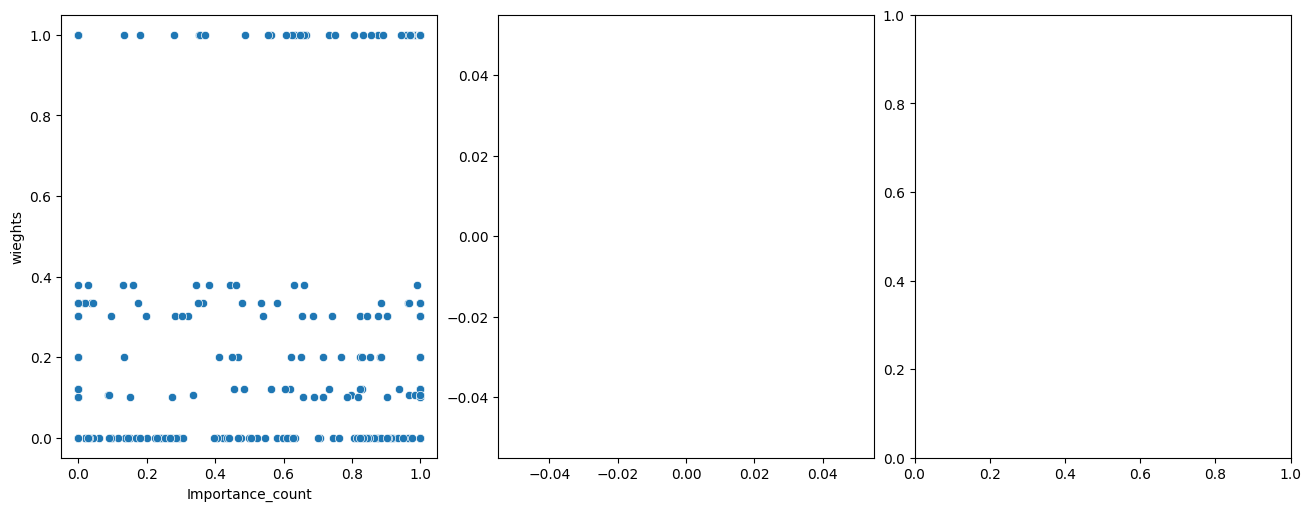

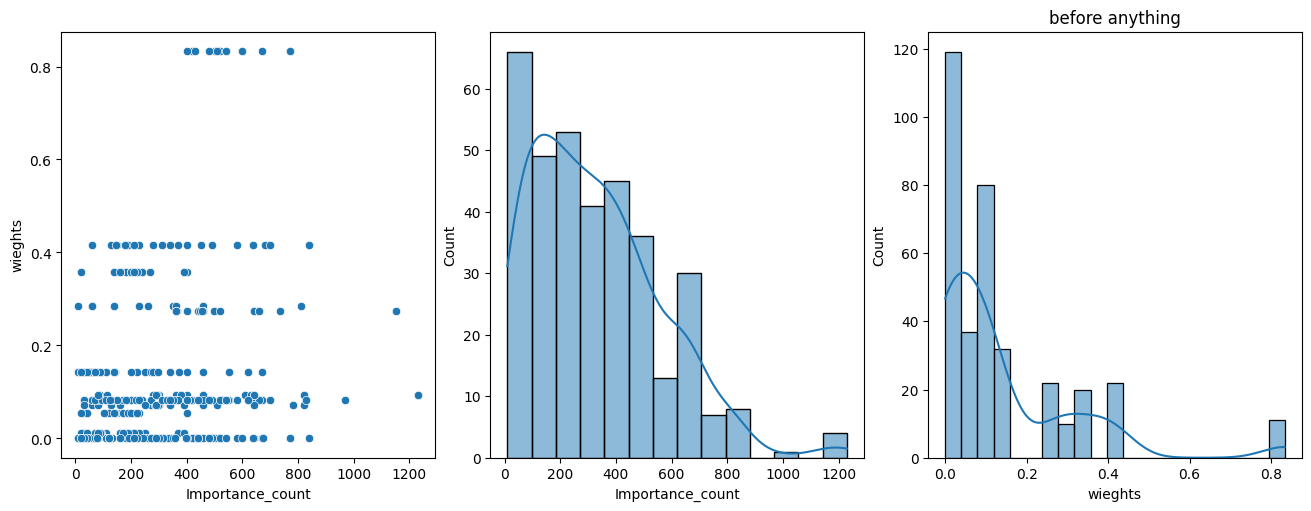

dsufuisgufis
      Importance_count   wieghts              level
0            0.000000  0.000000        hard_switch
1            0.015919  0.333333        hard_switch
2            0.175109  0.333333        hard_switch
3            0.985528  1.000000        hard_switch
4            1.000000  0.106667        hard_switch
..                ...       ...                ...
348          0.504505  0.000000  holmgard_9_potion
349          0.654655  0.303030  holmgard_9_potion
350          0.822823  0.000000  holmgard_9_potion
351          0.969970  1.000000  holmgard_9_potion
352          1.000000  1.000000  holmgard_9_potion

[353 rows x 3 columns]


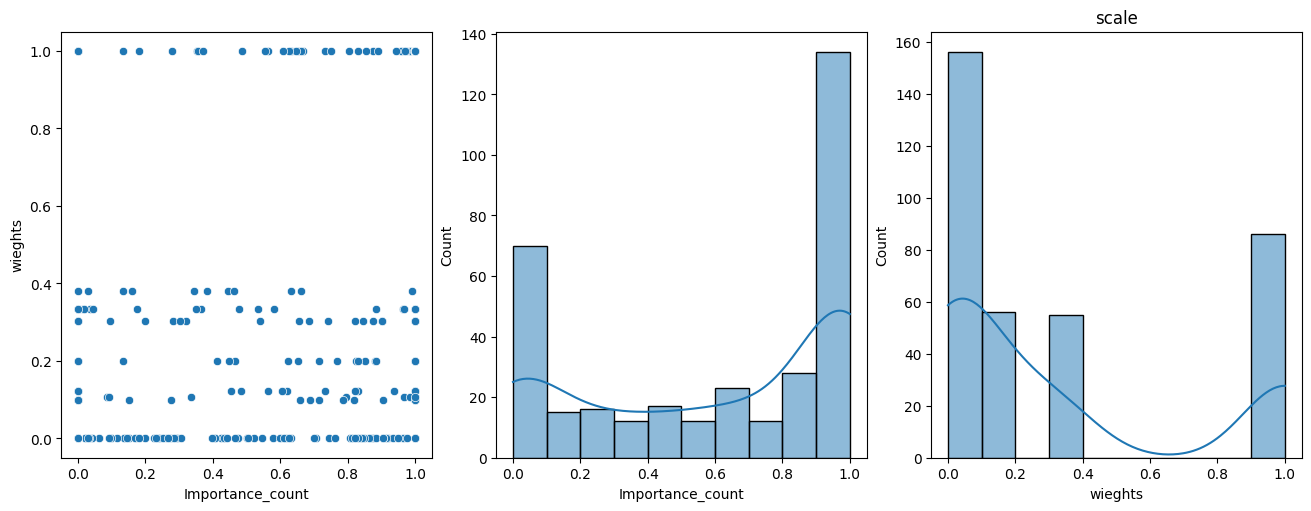

     Importance_count   wieghts              level
0            0.000000  0.000000        hard_switch
1            0.015919  0.333333        hard_switch
2            0.175109  0.333333        hard_switch
3            0.985528  1.000000        hard_switch
4            1.000000  0.106667        hard_switch
..                ...       ...                ...
348          0.504505  0.000000  holmgard_9_potion
349          0.654655  0.303030  holmgard_9_potion
350          0.822823  0.000000  holmgard_9_potion
351          0.969970  1.000000  holmgard_9_potion
352          1.000000  1.000000  holmgard_9_potion

[353 rows x 3 columns]


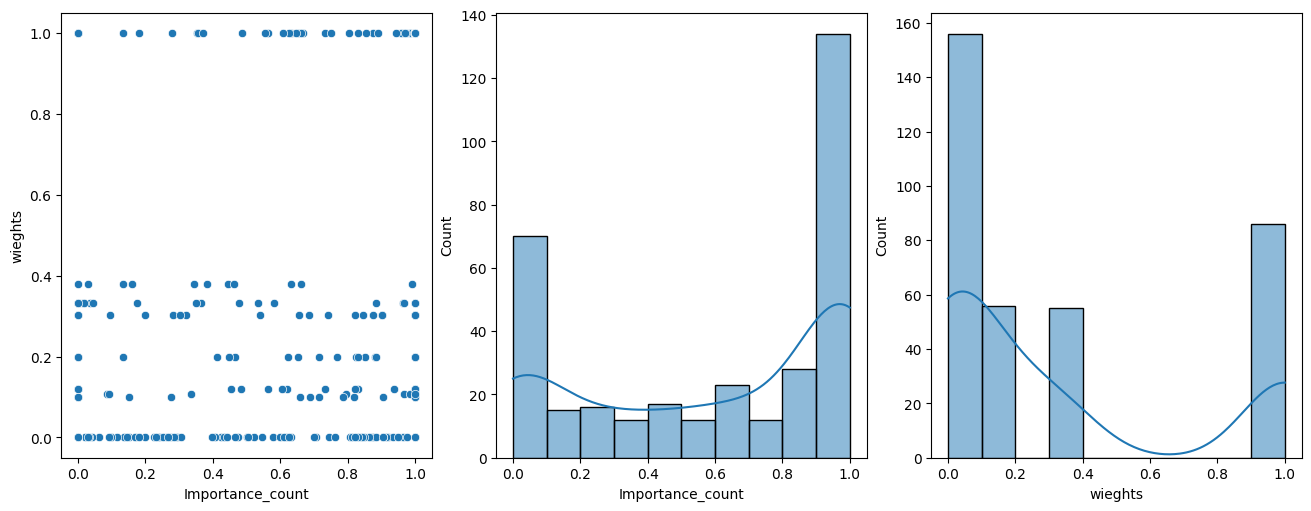

None


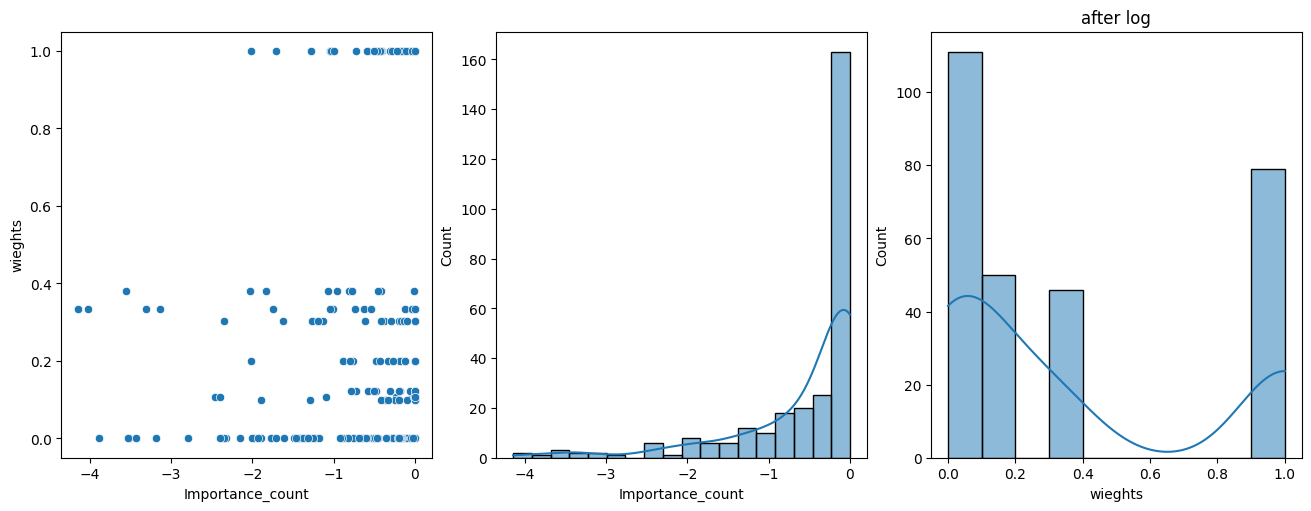

286


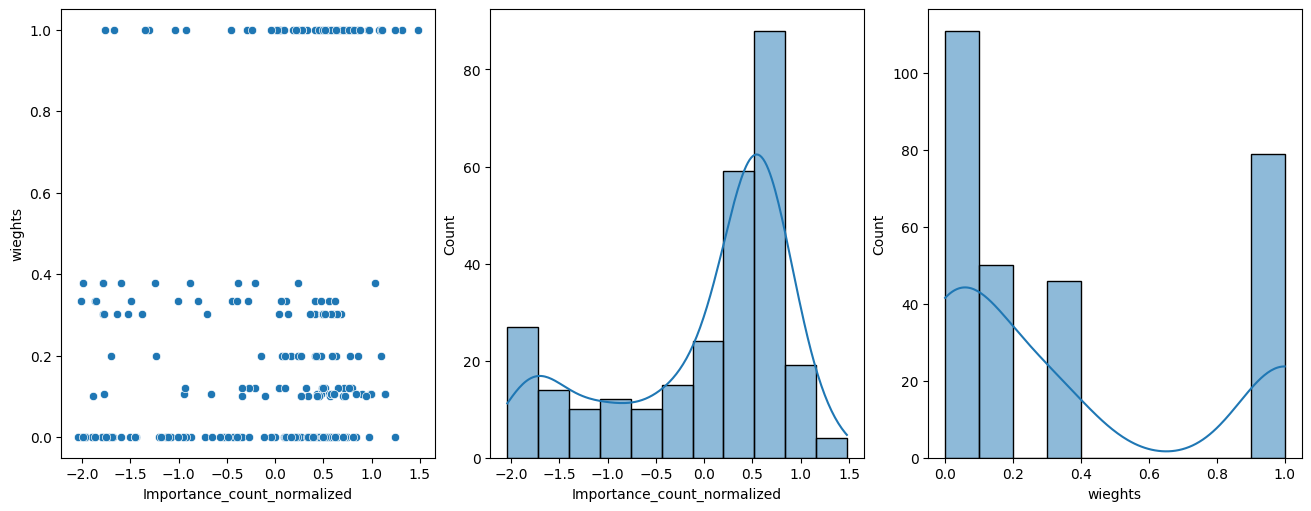

     Importance_count   wieghts              level  \
1           -4.140245  0.333333        hard_switch   
2           -1.742349  0.333333        hard_switch   
3           -0.014578  1.000000        hard_switch   
4            0.000000  0.106667        hard_switch   
5            0.000000  0.000000        hard_switch   
..                ...       ...                ...   
348         -0.684179  0.000000  holmgard_9_potion   
349         -0.423647  0.303030  holmgard_9_potion   
350         -0.195014  0.000000  holmgard_9_potion   
351         -0.030490  1.000000  holmgard_9_potion   
352          0.000000  1.000000  holmgard_9_potion   

     Importance_count_normalized  
1                      -1.861701  
2                      -0.447820  
3                       0.570934  
4                       0.579529  
5                       0.579529  
..                           ...  
348                    -0.483169  
349                     0.036915  
350                     0.493321  
3

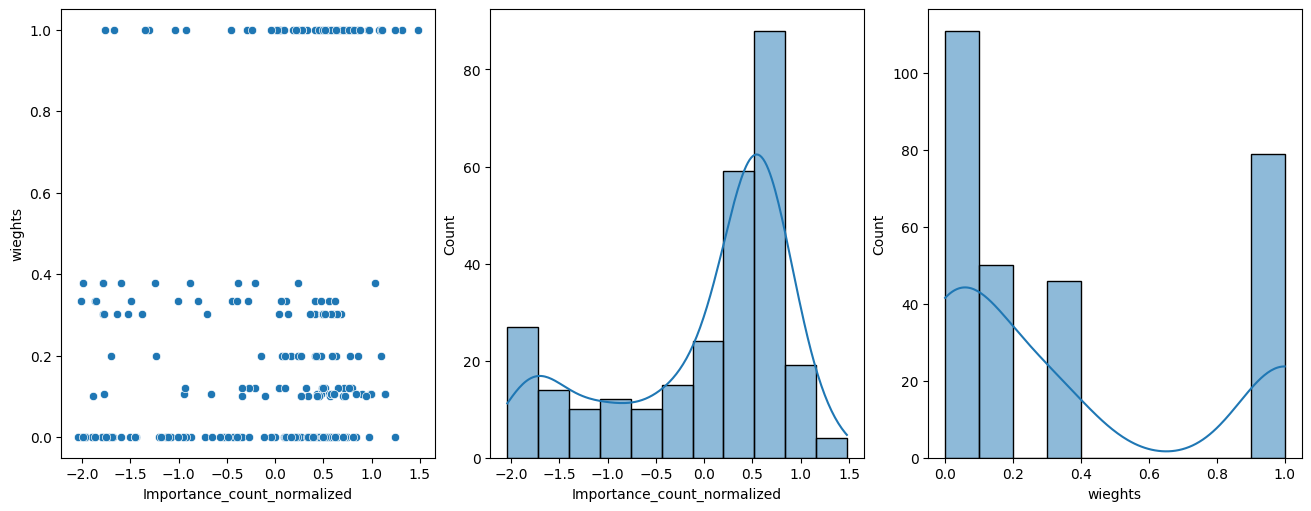

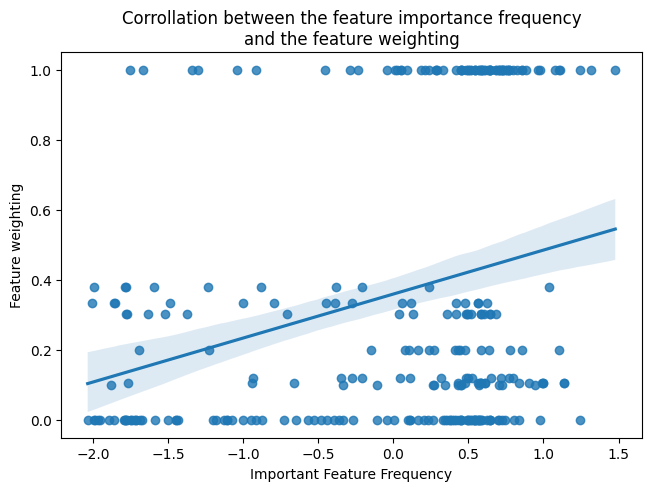

In [143]:



from pandas import DataFrame
from scipy import stats

groups_by_reward={
    "Exit": ["DE","SDE"],
    "Treasure": ["DT","SDT"],
    "Kill":["DM"],
    "Potion":["SDP","DP"],
    "HP": ["HP"]
}


def outlier_removal(df:DataFrame):
    return df[(np.abs(stats.zscore(df)) < 2.75).all(axis=1)]


def groupwise_scale(df:DataFrame, group_column, numeric_column)->DataFrame:
    # Initialize StandardScaler
    # Group by the categorical column
    grouped = df.groupby(group_column)
    # Normalize the numeric column within each group
    df[numeric_column] = grouped[numeric_column].transform(lambda x: (x - x.min())/ (x.max() - x.min()))
    return df

def groupwise_normalize(df:DataFrame, group_column, numeric_column)->DataFrame:
    # Initialize StandardScaler
    # Group by the categorical column
    grouped = df.groupby(group_column)
    # Normalize the numeric column within each group
    df[numeric_column + '_normalized'] = grouped[numeric_column].transform(lambda x: (x - x.mean()) / x.std())
    return df


fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(13,5))
for df in df_list:
    try:
        df.drop("HP",inplace=True)
    except:
        pass
merged_df = pd.concat(df_list,ignore_index=True)
print(merged_df)
# merged_df.drop("HP",inplace=True)
merged_df.reset_index(drop=True)
print(merged_df)

# plot before any preprocessing
sns.scatterplot(data=merged_df, x = 'Importance_count', y= 'wieghts',ax=ax[0])
sns.histplot(data=merged_df, x = 'Importance_count',ax=ax[1],kde=True)
sns.histplot(data=merged_df, x = 'wieghts',ax=ax[2],kde=True)
plt.title("before anything")
plt.show()

merged_df = groupwise_scale(df=merged_df, group_column='level', numeric_column='Importance_count')
# merged_df = groupwise_scale(df=merged_df, group_column='level', numeric_column='wieghts')
merged_df = groupwise_scale(df=merged_df, group_column='level', numeric_column='wieghts')
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(13,5))
print("dsufuisgufis\n",merged_df)
sns.scatterplot(data=merged_df, x = 'Importance_count', y= 'wieghts',ax=ax[0])
sns.histplot(data=merged_df, x = 'Importance_count',ax=ax[1],kde=True)
sns.histplot(data=merged_df, x = 'wieghts',ax=ax[2],kde=True)
plt.title("scale")
plt.show()

# cleaned_df = outlier_removal(merged_df[["Importance_count"]])
# print(cleaned_df)
# merged_df = merged_df.loc[set(merged_df.index) - set(list(cleaned_df.index))]
# merged_df =merged_df[merged_df.index.isin(cleaned_df.index)]
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(13,5))
sns.scatterplot(data=merged_df, x = 'Importance_count', y= 'wieghts',ax=ax[0])
sns.histplot(data=merged_df, x = 'Importance_count',ax=ax[1],kde=True)
sns.histplot(data=merged_df, x = 'wieghts',ax=ax[2],kde=True)
print(merged_df)
plt.show()


# log data
# merged_df['wieghts'] = np.log(merged_df['wieghts'])
merged_df['Importance_count'] = np.log(merged_df['Importance_count'])
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
print(merged_df.dropna(subset=["Importance_count", "wieghts"], how="any", inplace=True))

fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(13,5))
sns.scatterplot(data=merged_df, x = 'Importance_count', y= 'wieghts',ax=ax[0])
sns.histplot(data=merged_df, x = 'Importance_count',ax=ax[1],kde=True)
sns.histplot(data=merged_df, x = 'wieghts',ax=ax[2],kde=True)
plt.title("after log")
plt.show()
print(len(merged_df))
# remove outliers
# cleaned_df = outlier_removal(merged_df[["Importance_count"]])
# print(cleaned_df)
# # merged_df = merged_df.loc[set(merged_df.index) - set(list(cleaned_df.index))]
# merged_df =merged_df[merged_df.index.isin(cleaned_df.index)]
# fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(13,5))
# sns.scatterplot(data=merged_df, x = 'Importance_count', y= 'wieghts',ax=ax[0])
# sns.kdeplot(data=merged_df, x = 'Importance_count',ax=ax[1])
# sns.kdeplot(data=merged_df, x = 'wieghts',ax=ax[2])
# print(merged_df)
# plt.show()

# normalize_data
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(13,5))
merged_df = groupwise_normalize(df=merged_df, group_column='level', numeric_column='Importance_count')
sns.scatterplot(data=merged_df, x = 'Importance_count_normalized', y= 'wieghts',ax=ax[0])
sns.histplot(data=merged_df, x = 'Importance_count_normalized',ax=ax[1],kde=True)
sns.histplot(data=merged_df, x = 'wieghts',ax=ax[2],kde=True)
plt.show()

# remove outliers
# cleaned_df = outlier_removal(merged_df[["Importance_count_normalized"]])
# print(cleaned_df)
# # merged_df = merged_df.loc[set(merged_df.index) - set(list(cleaned_df.index))]
# merged_df =merged_df[merged_df.index.isin(cleaned_df.index)]
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(13,5))
sns.scatterplot(data=merged_df, x = 'Importance_count_normalized', y= 'wieghts',ax=ax[0])
sns.histplot(data=merged_df, x = 'Importance_count_normalized',ax=ax[1],kde=True)
sns.histplot(data=merged_df, x = 'wieghts',ax=ax[2],kde=True)
print(merged_df)
plt.show()

ax = plt.axes()
sns.regplot(data=merged_df[['Importance_count_normalized','wieghts']], x = 'Importance_count_normalized', y= 'wieghts',ax =ax)
ax.set_title("Corrollation between the feature importance frequency\nand the feature weighting")
ax.set_ylabel("Feature weighting")
ax.set_xlabel("Important Feature Frequency")
plt.show()


In [113]:
#gen analysis for all the levels
from IPython.display import clear_output
EXPLAINER_TYPE = 'deep'
CLASS_NAMES =['Killer','Treasure','Runner','Potion']
for lvl in lvl_list:
    # gen_analysis(analysis_loc='./test_analysis/Holmgard_2_Analysis/', lvl='holmgard_2', obs_type = 'distance', explainer_type =EXPLAINER_TYPE)
    gen_analysis(analysis_loc=f'./test_analysis/{lvl.capitalize()}_Analysis/',lvl=lvl, obs_type='distance', explainer_type='deep',exp_type='switch_analysis',exp_path = 'switching_analysis', base_path='play_style_models/base/')
    plt.close()
    clear_output()

     Importance_count   wieghts
DE              129.0  0.071429
DT              140.0  0.142857
SDT             250.0  0.142857
HP              311.0  0.094286
DM              810.0  0.285714
DP              820.0  0.094286
SDE             820.0  0.071429
SDP             820.0  0.094286
DP               31.0  0.011786
DM               90.0  0.142857
HP              319.0  0.011786
SDP             370.0  0.011786
DE              390.0  0.357143
SDE             400.0  0.357143
SDT             400.0  0.053571
DM               60.0  0.000000
DP               79.0  0.000000
SDP             331.0  0.000000
DE              359.0  0.083333
HP              591.0  0.000000
DT              680.0  0.416667
SDE             700.0  0.083333
SDT             700.0  0.416667
DM              520.0  0.833333
DP              520.0  0.000000
DT              520.0  0.000000
SDP             520.0  0.000000
SDT             520.0  0.000000
DT              200.0  0.000000
DE              330.0  0.083333
HP      

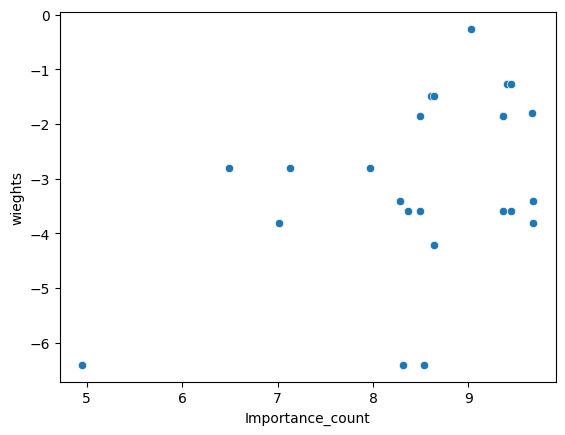

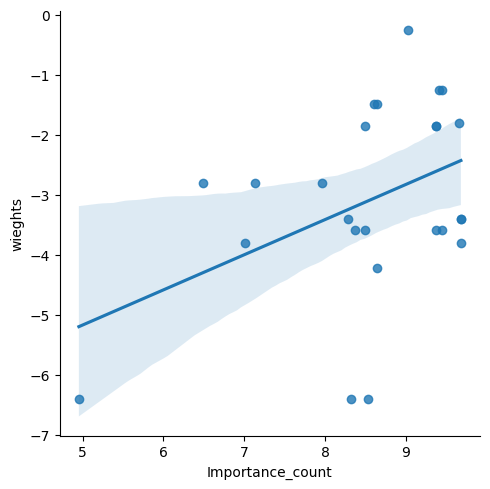

In [8]:
from sklearn.preprocessing import RobustScaler
from sklearn import linear_model

transformer = RobustScaler()
# merged_df = pd.concat(df_list,keys=['switch','hard','treasure','killer','potion','runner'])
merged_df = pd.concat(df_list)
# merged_df['wieghts'] = np.log(merged_df['wieghts'])
# merged_df['Importance_count'] = np.log(merged_df['Importance_count'])

# normalizer = preprocessing.StandardScaler()
print(merged_df[["Importance_count","wieghts"]])
# merged_df["wieghts"] = merged_df['wieghts'].replace(0.0 , 0.001)
# normalizer = preprocessing.MinMaxScaler()


# scaled = normalizer.fit_transform(merged_df[["Importance_count","wieghts"]].values)
# merged_df["Importance_count"] = scaled[:,0]
# merged_df["wieghts"] = scaled[:,1]
merged_df['wieghts'] = np.log2(merged_df['wieghts'])
merged_df['Importance_count'] = np.log2(merged_df['Importance_count'])
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df.dropna(subset=["Importance_count", "wieghts"], how="all", inplace=True)
# reg = linear_model.LinearRegression().fit(merged_df['Importance_count'].values,merged_df['wieghts'].values)
# sns.scatterplot(data=merged_df, x = np.log(merged_df['Importance_count']), y= np.log(merged_df['wieghts']))
# sns.scatterplot(data=merged_df, x = np.exp(merged_df['Importance_count']), y= np.exp(merged_df['wieghts']))
# sns.scatterplot(data=merged_df, x = np.exp(merged_df['Importance_count']), y= np.exp(merged_df['wieghts']))
ax =sns.scatterplot(data=merged_df, x = 'Importance_count', y= 'wieghts')
# plt.plot(merged_df['Importance_count'].values.T,reg.predict(merged_df['Importance_count'].values.T),ax=ax)
sns.lmplot(data=merged_df[['Importance_count','wieghts']], x = 'Importance_count', y= 'wieghts')




{'DE': 0.08333333333333333, 'SDE': 0.08333333333333333, 'DT': 0.4166666666666667, 'SDT': 0.4166666666666667, 'DM': 0.0, 'DP': 0.0, 'SDP': 0.0, 'HP': 0.0}


<Axes: xlabel='wieghts', ylabel='Importance_count'>

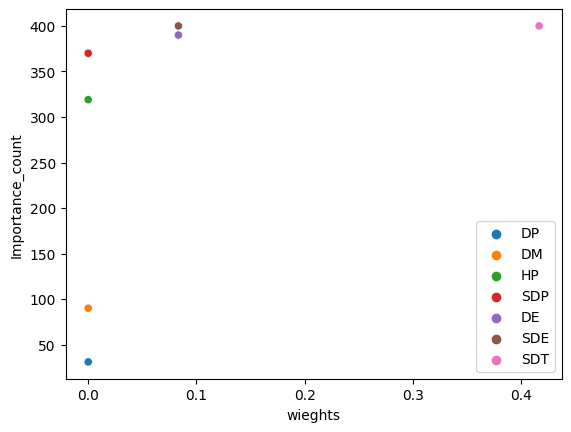

In [63]:

df_shap = df[['level','curr_obs', 'action']]
shap_valss = []
policy_classes = ['killer','treasure','runner','potion']

reshaped_shap_vals = np.transpose(np.array(shap_vals),(1,0,2))
action_shap_vals=[]
for i, row in df.iterrows():
    action = row['action']
    # get action taken index
    action_idx = policy_classes.index(action.lower())
    action_shap_vals.append(reshaped_shap_vals[i][action_idx])

# Add shap_vals to the dataframe
df_shap["shap_vals"] = pd.Series(action_shap_vals)
df_shap[obs_names] = pd.DataFrame(df_shap.shap_vals.to_list(), index = df_shap.index)

# get the top five features for each state
df_shap= df_shap.join(pd.DataFrame(df_shap[obs_names].abs().apply(lambda x: x.nlargest(5).index.tolist(), axis=1).tolist(), columns=['1st','2nd','3rd','4th','5th']))

# create rankings dataframe for the whole level by adding up the value counts
df_rankings = df_shap[['1st','2nd','3rd','4th','5th']].apply(pd.Series.value_counts).sum(axis=1)
df_rankings = pd.DataFrame(data=df_rankings,columns=['Importance_count']).sort_values(by='Importance_count')
imp_w = get_imporance_weights("treasure")
df_rankings['wieghts'] = df_rankings.index.map(imp_w)
# df_rankings =df_rankings.T
df_rankings['level'] = df_shap['level'].unique()[0]
# df_rankings

print(imp_w)
df_rankings
sns.scatterplot(data =df_rankings, x = 'wieghts',y ="Importance_count",hue=df_rankings.index)

# df_shap

## gen Data

10
----------Generating Action Data----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'switch', 'reward_scheme': 'switch', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_switch_switch_grid_12x12_switch_analysis_PPO


[ WARN:0@6.010] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-hard-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'hard', 'reward_scheme': 'hard', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_hard_hard_grid_12x12_switch_analysis_PPO


[ WARN:0@8.222] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-hard-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'treasure', 'reward_scheme': 'treasure', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_treasure_treasure_grid_12x12_switch_analysis_PPO


[ WARN:0@10.179] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-hard-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'killer', 'reward_scheme': 'killer', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_killer_killer_grid_12x12_switch_analysis_PPO


[ WARN:0@11.726] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-hard-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'potion', 'reward_scheme': 'potion', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_potion_potion_grid_12x12_switch_analysis_PPO


[ WARN:0@13.803] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-hard-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'runner', 'reward_scheme': 'runner', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_runner_runner_grid_12x12_switch_analysis_PPO


[ WARN:0@14.705] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-hard-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
{'action_type': 'base', 'action_space_type': 'box', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'treasure', 'reward_scheme': 'fiftytwoFifty', 'exp_type': 'treasure', 'learning_algo': 'PPO', 'exp_path': 'play_style_models/grid_base_12x12/', 'base_path': 'play_style_models/grid_base_12x12/'}
base-hard_treasure_fiftytwoFifty_treasure_PPO


[ WARN:0@15.756] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-hard-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
{'action_type': 'base', 'action_space_type': 'box', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'killer', 'reward_scheme': 'fiftytwoFifty', 'exp_type': 'killer', 'learning_algo': 'PPO', 'exp_path': 'play_style_models/grid_base_12x12/', 'base_path': 'play_style_models/grid_base_12x12/'}
base-hard_killer_fiftytwoFifty_killer_PPO


[ WARN:0@16.999] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-hard-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
{'action_type': 'base', 'action_space_type': 'box', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'potion', 'reward_scheme': 'fiftytwoFifty', 'exp_type': 'potion', 'learning_algo': 'PPO', 'exp_path': 'play_style_models/grid_base_12x12/', 'base_path': 'play_style_models/grid_base_12x12/'}
base-hard_potion_fiftytwoFifty_potion_PPO


[ WARN:0@37.575] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-hard-v0_step0.png'): can't open/read file: check file path/integrity


----------Generating Data----------
{'action_type': 'base', 'action_space_type': 'box', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'runner', 'reward_scheme': 'fiftytwoFifty', 'exp_type': 'runner', 'learning_algo': 'PPO', 'exp_path': 'play_style_models/grid_base_12x12/', 'base_path': 'play_style_models/grid_base_12x12/'}
base-hard_runner_fiftytwoFifty_runner_PPO


[ WARN:0@38.002] global loadsave.cpp:244 findDecoder imread_('./README/resources/md_stages_screenshots/md-hard-v0_step0.png'): can't open/read file: check file path/integrity


<Figure size 640x480 with 0 Axes>

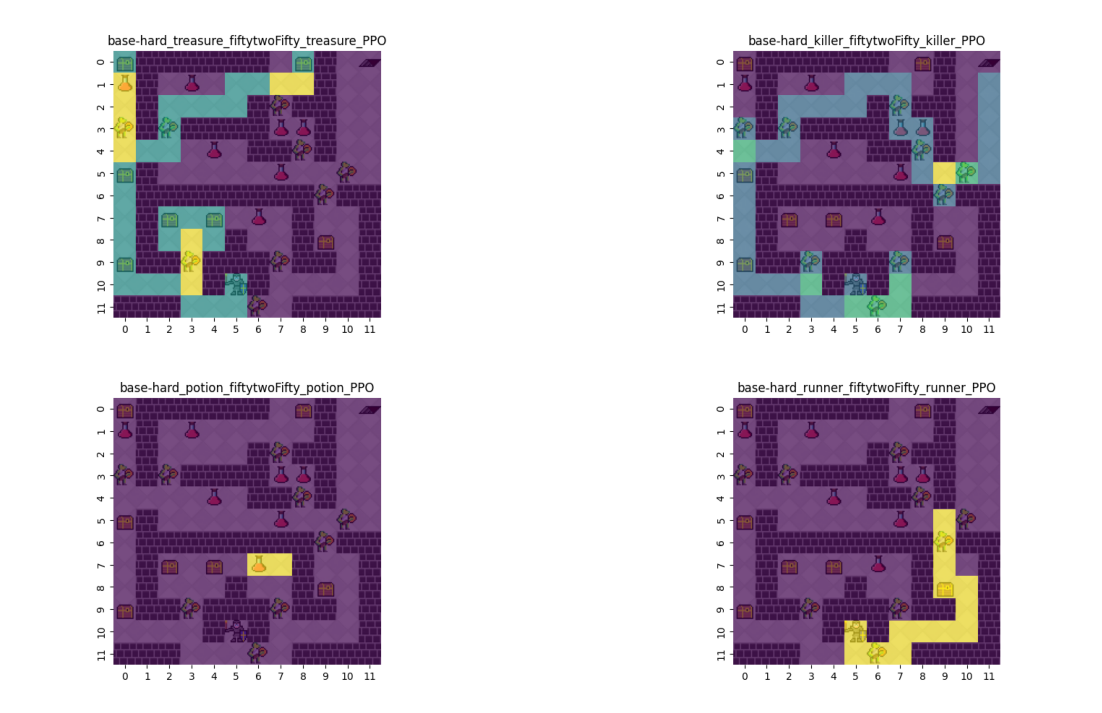

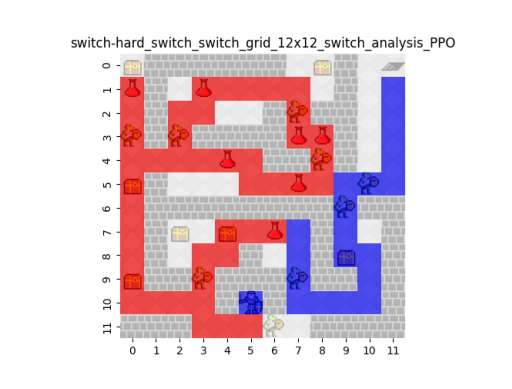

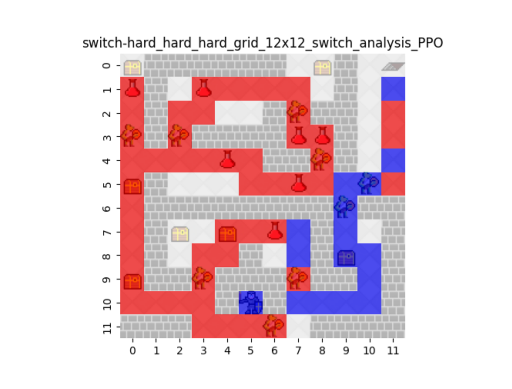

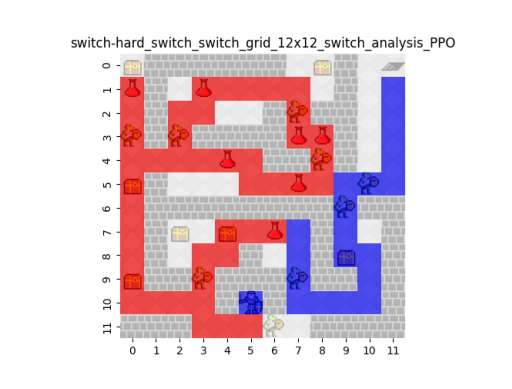

----------Perfroming Shapley Analysis----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'switch', 'reward_scheme': 'switch', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_switch_switch_grid_12x12_switch_analysis_PPO
action
POTION    581
RUNNER    199
Name: count, dtype: int64
(4, 780, 12, 12)
(12, 12)
(780, 4, 12, 12)
(12, 12)


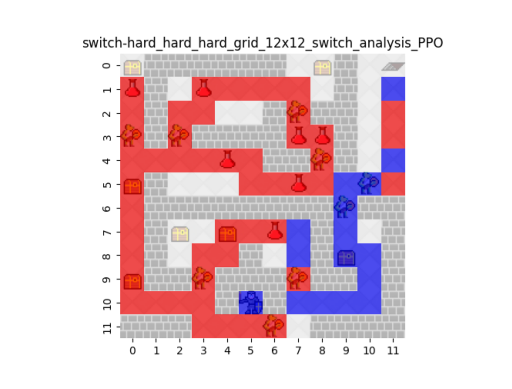

----------Perfroming Shapley Analysis----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'hard', 'reward_scheme': 'hard', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_hard_hard_grid_12x12_switch_analysis_PPO
action
POTION    631
RUNNER    169
Name: count, dtype: int64
(4, 800, 12, 12)
(12, 12)
(800, 4, 12, 12)
(12, 12)


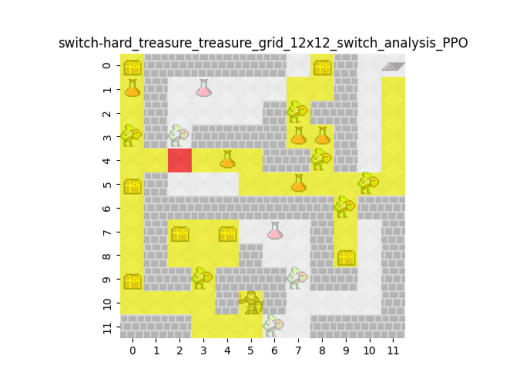

----------Perfroming Shapley Analysis----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'treasure', 'reward_scheme': 'treasure', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_treasure_treasure_grid_12x12_switch_analysis_PPO
action
TREASURE    690
POTION       10
Name: count, dtype: int64
(4, 700, 12, 12)
(12, 12)
(700, 4, 12, 12)
(12, 12)


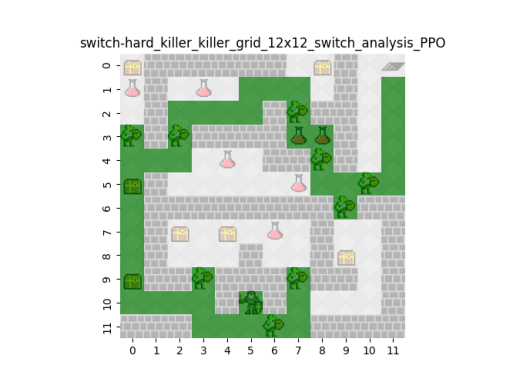

----------Perfroming Shapley Analysis----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'killer', 'reward_scheme': 'killer', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_killer_killer_grid_12x12_switch_analysis_PPO
action
KILLER    520
Name: count, dtype: int64
(4, 520, 12, 12)
(12, 12)
(520, 4, 12, 12)
(12, 12)


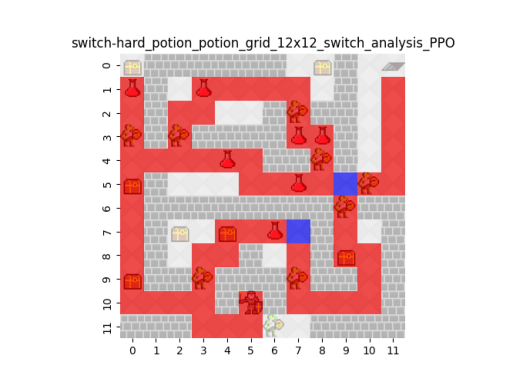

----------Perfroming Shapley Analysis----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'potion', 'reward_scheme': 'potion', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_potion_potion_grid_12x12_switch_analysis_PPO
action
POTION    760
RUNNER     20
Name: count, dtype: int64
(4, 780, 12, 12)
(12, 12)
(780, 4, 12, 12)
(12, 12)


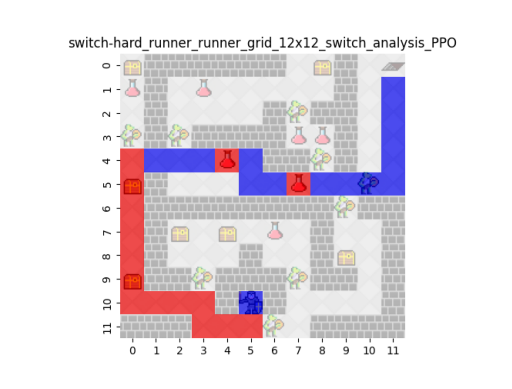

----------Perfroming Shapley Analysis----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'runner', 'reward_scheme': 'runner', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_runner_runner_grid_12x12_switch_analysis_PPO
action
POTION    151
RUNNER    149
Name: count, dtype: int64
(4, 300, 12, 12)
(12, 12)
(300, 4, 12, 12)
(12, 12)


<Figure size 640x480 with 0 Axes>

In [3]:
# configs = gen_config(lvl = 'holmgard_1', algo='PPO',obs_type='distance', switch_path='switching_analysis',  base_path='play_style_models/base/')
# print(configs[0])
# explainer, shap_vals, data, df = shappy(configs[0])
gen_analysis(analysis_loc='./test_analysis/grid/Hard_Analysis/',lvl='hard', obs_type='grid', explainer_type='deep',exp_type='grid_12x12_switch_analysis',exp_path = 'switching_grid_12x12_analysis', base_path='play_style_models/grid_base_12x12/')

In [4]:
df.head()

,experiment,level,run,step,x,y,hp,curr_grid,grid,play_style,action,curr_obs,observation,done,reward,info,grid_rows,grid_columns
0,switch-check_1_switch_switch_switch_analysis_PPO,check_1,0,0,4,11,40,"[[0, 3, 0, 4, 0, 1, 4, 2, 1, 4, 0, 0], [1, 1, ...","[[0, 3, 0, 4, 0, 1, 4, 2, 1, 4, 0, 0], [1, 1, ...",switch,POTION,"[4, 2, 2, 4, 4, 17, 17, 40]","[3, 1, 1, 3, 3, 16, 16, 40]",False,-4.0,"{'action_taken': 'POTION', 'POTION': 1, '.': 1}",12,12
1,switch-check_1_switch_switch_switch_analysis_PPO,check_1,0,1,4,10,40,"[[0, 3, 0, 4, 0, 1, 4, 2, 1, 4, 0, 0], [1, 1, ...","[[0, 3, 0, 4, 0, 1, 4, 2, 1, 4, 0, 0], [1, 1, ...",switch,POTION,"[3, 1, 1, 3, 3, 16, 16, 40]","[4, 2, 2, 2, 2, 15, 15, 40]",False,-4.0,"{'action_taken': 'POTION', 'POTION': 2, '.': 2}",12,12
2,switch-check_1_switch_switch_switch_analysis_PPO,check_1,0,2,5,10,40,"[[0, 3, 0, 4, 0, 1, 4, 2, 1, 4, 0, 0], [1, 1, ...","[[0, 3, 0, 4, 0, 1, 4, 2, 1, 4, 0, 0], [1, 1, ...",switch,POTION,"[4, 2, 2, 2, 2, 15, 15, 40]","[5, 3, 3, 1, 1, 14, 14, 40]",False,-4.0,"{'action_taken': 'POTION', 'POTION': 3, '.': 3}",12,12
3,switch-check_1_switch_switch_switch_analysis_PPO,check_1,0,3,6,10,40,"[[0, 3, 0, 4, 0, 1, 4, 2, 1, 4, 0, 0], [1, 1, ...","[[0, 3, 0, 4, 0, 1, 4, 2, 1, 4, 0, 0], [1, 1, ...",switch,POTION,"[5, 3, 3, 1, 1, 14, 14, 40]","[5, 4, 4, 0, 0, 13, 13, 50]",False,-2.0,"{'action_taken': 'POTION', 'POTION': 4, '.': 3...",12,12
4,switch-check_1_switch_switch_switch_analysis_PPO,check_1,0,4,7,10,50,"[[0, 3, 0, 4, 0, 1, 4, 2, 1, 4, 0, 0], [1, 1, ...","[[0, 3, 0, 4, 0, 1, 4, 2, 1, 4, 0, 0], [1, 1, ...",switch,POTION,"[5, 4, 4, 0, 0, 13, 13, 50]","[4, 5, 5, 1, 1, 14, 14, 50]",False,-4.0,"{'action_taken': 'POTION', 'POTION': 5, '.': 4...",12,12


----------------------------------------------------Generting quantitative results-------------------------------------------


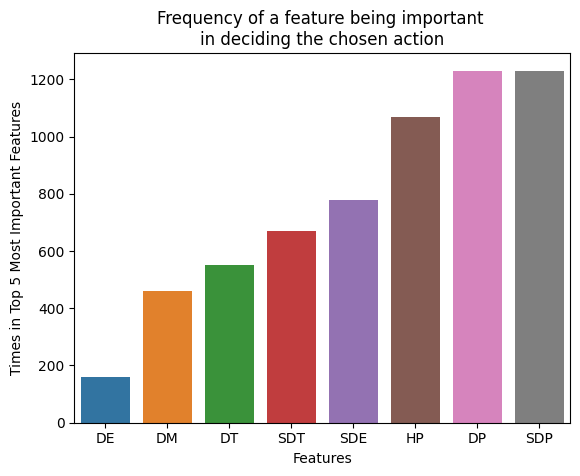

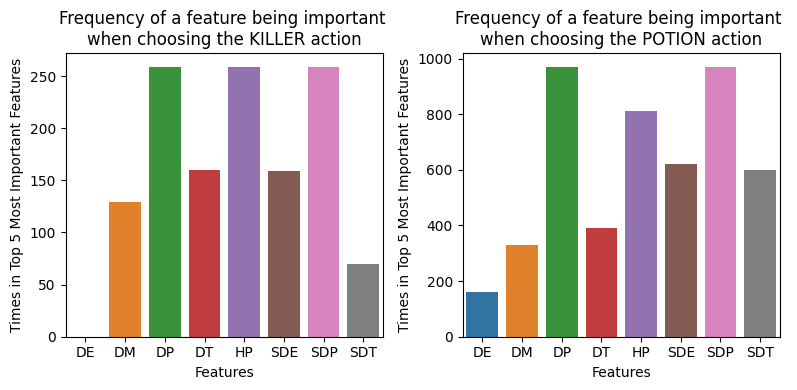

In [5]:
df_shap, df_rankings, df_action_rankings = qauntitative_results(explainer=explainer,shap_vals=shap_vals, data=data, df=df)

     Importance_count
DE              160.0
DM              459.0
DT              550.0
SDT             671.0
SDE             780.0
HP             1070.0
DP             1230.0
SDP            1230.0


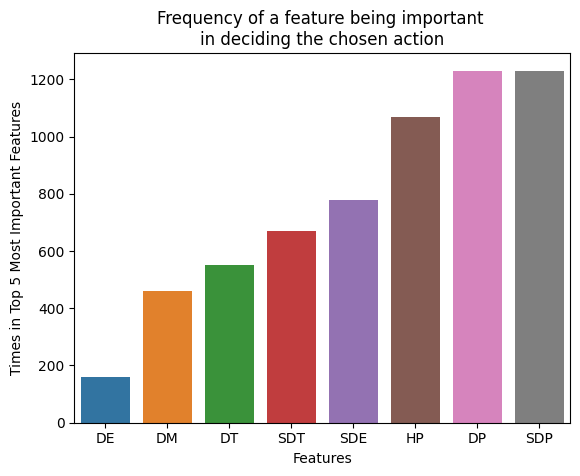

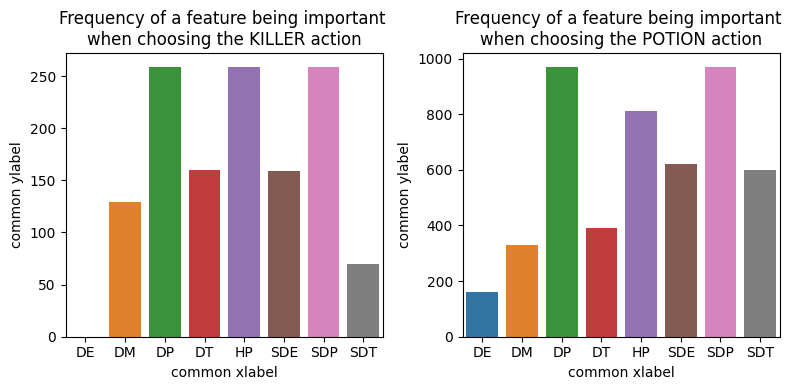

value,DE,DM,DP,DT,HP,SDE,SDP,SDT
action,,,,,,,,
KILLER,0,129,259,160,259,159,259,70
POTION,160,330,971,390,811,621,971,601


In [6]:
# create shap value df
df_shap = df[['curr_obs', 'action']]
shap_valss = []
policy_classes = ['killer','treasure','runner','potion']

#
reshaped_shap_vals = np.transpose(np.array(shap_vals),(1,0,2))
action_shap_vals=[]
#get shap_vals for chosen action
for i, row in df.iterrows():
    action = row['action']
    # get action taken index
    action_idx = policy_classes.index(action.lower())
    action_shap_vals.append(reshaped_shap_vals[i][action_idx])

# Add shap_vals to the dataframe
df_shap["shap_vals"] = pd.Series(action_shap_vals)
df_shap[obs_names] = pd.DataFrame(df_shap.shap_vals.to_list(), index = df_shap.index)

# get the top five features for each state
df_shap= df_shap.join(pd.DataFrame(df_shap[obs_names].abs().apply(lambda x: x.nlargest(5).index.tolist(), axis=1).tolist(), columns=['1st','2nd','3rd','4th','5th']))

# create rankings dataframe for the whole level by adding up the value counts
df_rankings = df_shap[['1st','2nd','3rd','4th','5th']].apply(pd.Series.value_counts).sum(axis=1)
df_rankings = pd.DataFrame(data=df_rankings,columns=['Importance_count']).sort_values(by='Importance_count')
print(df_rankings)

def plot_frequency(ax, x, y, xlabel, ylabel, title):
    sns.barplot(x=x, y=y, ax=ax)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)

ax = sns.barplot(x=df_rankings.index, y=df_rankings.Importance_count)
ax.set(xlabel='Features', ylabel='Times in Top 5 Most Important Features', title="Frequency of a feature being important \nin deciding the chosen action")

melted_df = pd.melt(df_shap[['action','1st','2nd','3rd','4th','5th']], id_vars=['action'], value_vars=['1st', '2nd', '3rd', '4th', '5th'])
df_action_rankings = pd.crosstab(index=melted_df['action'], columns=melted_df['value'])

fig, ax = plt.subplots(1, len(df_action_rankings), figsize=(4 * len(df_action_rankings), 4))

for i in range(len(df_action_rankings)):
    plot_frequency(ax[i], df_action_rankings.columns, df_action_rankings.iloc[i],
                   xlabel='common xlabel', ylabel='common ylabel',
                   title=f"Frequency of a feature being important \nwhen choosing the {df_action_rankings.index[i]} action")

plt.tight_layout()
plt.show()

df_action_rankings


## Grid 12x12 stuff


In [10]:
# configs = gen_config(lvl = 'hard', algo='PPO',obs_type='grid', switch_path='switching_grid_12x12_analysis',  base_path='play_style_models/grid_base_12x12/')
config_switch ={
        'action_type': 'switch',
        'action_space_type': 'discrete',
        'obs_type': "grid",
        'lvl': 'hard',
        'play_style': 'switch',
        'reward_scheme': 'switch',
        'exp_type': 'grid_12x12_switch_analysis',
        'learning_algo': 'PPO',
        'exp_path': 'switching_grid_12x12_analysis',
        'base_path': 'play_style_models/grid_base_12x12/',
    }
print(config_switch)
from md_shap import gen_data, sb3Wrapper, sb3_DQN_wrapper
from torch import float32
from torch.autograd import Variable

class sb3Wrapper(nn.Module):
    def __init__(self, model):
        super(sb3Wrapper,self).__init__()
        self.extractor = model.policy.mlp_extractor
        self.policy_net = model.policy.mlp_extractor.policy_net
        self.action_net = model.policy.action_net

    def forward(self,x):
        x = torch.flatten(x,start_dim=1)
        x = self.policy_net(x)
        x = self.action_net(x)
        return x

def shappy(config,explainer_type ='deep'):
    print('----------Perfroming Shapley Analysis----------')
    action_type = config['action_type']
    exp_type =config['exp_type']
    lvl = config['lvl']
    play_style= config['play_style']
    reward_scheme=config['reward_scheme']
    algo= config['learning_algo']
    path = config['exp_path']
    #generate data
    data =gen_data(config)
    df = pd.DataFrame(data, columns=['experiment','level','run','step','x','y','hp','curr_grid','grid','play_style','action','curr_obs','observation','done','reward','info','grid_rows','grid_columns'])
    print(df['action'].value_counts())
    df_to_analyse = df[df['action'].isin({f'{play_style.upper()}', f'{play_style.upper()}_SAFELY'})]
    # print(df_to_analyse[['action', 'observation']])
    # print(df[['action','observation']])
    #load PPO model
    if action_type == "switch":
        exp = f"{action_type}-{lvl}_{play_style}_{reward_scheme}_{exp_type}_{algo}"
        model_path = f"logs/{path}/{exp}/{play_style}/best_model"
    else:
        exp = f"{lvl}_{play_style}_{reward_scheme}_{exp_type}"
        model_path = f"logs/{path}/{exp}/best_model/best_model"

    if algo =="PPO":
        model = PPO.load(model_path, device='cuda')
    elif algo =='DQN':
        model = DQN.load(model_path, device='cuda')
    state_log = np.array(df['curr_obs'].values.tolist())
    data =torch.FloatTensor(state_log).to('cuda')
    print(data.shape)
    # print(model.policy)
    # print(model.policy.q_net.q_net)
    # print(model.policy.feature)
    if algo =='PPO':
        model = sb3Wrapper(model)
    elif algo == 'DQN':
        model = sb3_DQN_wrapper(model)
    

    if explainer_type == "kernel":
        f = lambda x: model.forward(Variable(torch.from_numpy(x)).to(float32).cuda()).detach().cpu().numpy()
        explainer = shap.KernelExplainer(f, state_log)
        shap_vals= explainer.shap_values(state_log)
    else:
        explainer = shap.DeepExplainer(model, data)
        shap_vals= explainer.shap_values(data,check_additivity=True)

    # explainer=shap.Explainer(model.forward,data)
    # shap_vals= explainer.shap_values(state_log)
    # return
    return explainer, shap_vals, data, df


explainer, shap_vals, data, df = shappy(config_switch)

{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'switch', 'reward_scheme': 'switch', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
----------Perfroming Shapley Analysis----------
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'grid', 'lvl': 'hard', 'play_style': 'switch', 'reward_scheme': 'switch', 'exp_type': 'grid_12x12_switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_grid_12x12_analysis', 'base_path': 'play_style_models/grid_base_12x12/'}
switch-hard_switch_switch_grid_12x12_switch_analysis_PPO
action
POTION    581
RUNNER    199
Name: count, dtype: int64
torch.Size([780, 12, 12])


In [22]:
from md_shap import state_image,convert_fig, make_state_gif
from PIL import Image
import cv2
import imageio
import os

# configs = gen_config(lvl = 'holmgard_1', algo='PPO',obs_type='distance', switch_path='switching_analysis',  base_path='play_style_models/base/')
# print(configs[0])
# explainer, shap_vals, data, df = shappy(configs[0])
# print(np.array(shap_vals).shape)
# print(shap_vals[0][0])
def gen_grid_shap(shap_vals,df, save_loc):
    policy_classes = ['killer','treasure','runner','potion']
    state_loc = f"{save_loc}state_shap_images/"
    os.makedirs(state_loc,exist_ok=True)  
    shap_vals = np.array(shap_vals)
    print(shap_vals.shape)
    print(shap_vals[0][0].shape)
    reshaped_shap_vals = np.transpose(np.array(shap_vals),(1,0,2,3))
    print(reshaped_shap_vals.shape)
    print(reshaped_shap_vals[0][0].shape)
    df_shap = df[['run','x','y','hp','curr_obs', 'action']]
    # print(sha)
    action_shap_vals=[]
    #get shap_vals for chosen action
    for i, row in df.iterrows():
        action = row['action']
        # get action taken index
        action_idx = policy_classes.index(action.lower())
        action_shap_vals.append(reshaped_shap_vals[i][action_idx])

    # Add shap_vals to the dataframe
    df_shap["shap_vals"] = pd.Series(action_shap_vals)
    images =[]
    temp =df_shap[(df_shap['run']==0)]
    temp
    for i, row in df_shap[(df_shap['run']==0)].iterrows():
        # print(row.shap_vals.shape)
        # newcmp = ListedColormap(GradientBlueRed_res, name='BlueRed')
        heat =sns.heatmap(row.shap_vals,cmap='bwr',alpha= 0.6,zorder=2, center=0.0)
        # gen state image
        state = state_image(row['curr_obs'],row['x'],row['y'],row['hp'])
        # state = state_image(df_shap['curr_obs'].iloc[0],df['x'].iloc[0],df['y'].iloc[0],df['hp'].iloc[0])
        # state = cv2.cvtColor(state, cv2.COLOR_BGR2RGB)
        img = heat.imshow(state,aspect=heat.get_aspect(),extent= heat.get_xlim() + heat.get_ylim(),zorder=1)
        plt.title(f"Action: {row['action']}")
        img = convert_fig(plt)
        images.append(img)
        Image.fromarray(img).save(f'{state_loc}state{i}.png')

        # cv2.imwrite(f'/gifs/state_images/state{i}.png',img)
        plt.clf()

    # images[0].save(f"{state_loc}.pdf", save_all = True, append_images= images[1:])

    # make_state_gif(images, './gifs/AAA.gif')
    # images[0].save("/gifs/array.gif", save_all=True, append_images=img[1:], duration=50, loop=0)
    imageio.mimsave(f'{state_loc}State_Shap_Gif.gif', images,duration=1000)
    imageio.mimsave(f'{state_loc}State_shap.pdf', images)


gen_grid_shap(shap_vals=shap_vals,df=df,save_loc='./test_analysis/kernel/')
# print(len(images))

(4, 780, 12, 12)
(12, 12)
(780, 4, 12, 12)
(12, 12)


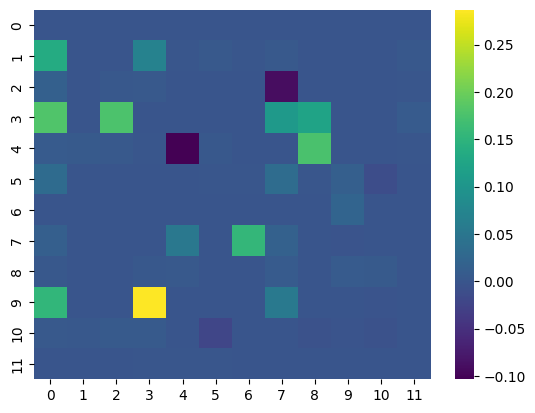

In [141]:
sns.heatmap(reshaped_shap_vals[0][-1],cmap='viridis')
import shap
def gen_heatmap(df,f):
    df = df.reset_index()
    x_array = df['x'].to_numpy()
    y_array =df['y'].to_numpy()
    grid = np.zeros((df['grid_rows'][0],df['grid_columns'][0]))
    for i, j in zip(y_array,x_array):
        grid[i,j]+=1
    heat =sns.heatmap(grid,cmap='viridis',alpha =0.4,zorder=2, cbar = False)
    my_image = cv2.imread(f)
    my_image = cv2.cvtColor(my_image, cv2.COLOR_BGR2RGB)
    # plt.imshow(my_image)
    plt.title(df['experiment'][0])
    # print(heat.get_aspect())
    img = heat.imshow(my_image,extent= heat.get_xlim() + heat.get_ylim(),zorder=1)
    # img = convert_fig(plt)
    plt.clf()
    return img



In [120]:
print(reshaped_shap_vals[0][0])

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.49955538e-02  0.00000000e+00  0.00000000e+00 -2.09637601e-02
  -2.83726695e-04 -1.55455468e-03 -5.50014258e-04 -1.75702514e-03
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.49742991e-03]
 [-4.24832618e-03  0.00000000e+00 -9.28505789e-04 -1.24583824e-03
   0.00000000e+00  0.00000000e+00  0.00000000e+00  3.98908965e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.03422673e-03]
 [-4.13406827e-02  0.00000000e+00 -4.93541136e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.60427445e-02
  -2.44637225e-02  0.00000000e+00  0.00000000e+00 -1.88381691e-03]
 [-3.58888577e-03 -1.24583067e-03 -1.89840689e-03 -6.32103300e-04
   2.62027662e-02 -1.40355248e-03  0.00000000e+00  0.00000000e+00
  -5.86012192e-02  0.00000000e+00  0.00000000e+00 -1.80663448e-03]
 [-7.